# Business Question

The New York Times is reevaluating the comment moderation on its web content, in hopes of stimulating reader engagement, deepening the quality of user feedback, and identifying potentially problematic comments more quickly. They would like to use the existing recommendation tool to develop a machine learning model that will predict which comments will be most popular and which comments will be most likely to generate further engagement. The end goal will be to sort comments according to this prediction (as a third option available to users in addition to presenting comments ranked in response to recommendations or chronologically). Additionally, they would like to identify comments that are most likely to be flagged as abuse to bring these comments to the attention of moderators more quickly. 

### Data Acquisition
The data used for this project represents articles and comments on The New York Times website in April 2017. I downloaded the dataset from Kaggle [at this address](https://www.kaggle.com/aashita/nyt-comments). The data was originally collected using the New York Times API. The process for this collection is well-documented on the Kaggle page. 

In [31]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.pipeline import Pipeline

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist

import gc

#hate speech library
!pip install hatesonar
from hatesonar import Sonar

#toggle variable to print previews, 'sanity checks'
print_detail = True

In [33]:
#load stopwords for NLP
nltk.download('stopwords')
nltk.download('wordnet')
#create stopwords set for computational efficiency
stopwords_set = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Preprocessing

In [34]:
#load in datasets
#articles dataset
art = pd.read_csv('gdrive/MyDrive/data/ArticlesApril2018.csv')
#comments dataset
comm = pd.read_csv('gdrive/MyDrive/data/CommentsApril2018.csv')
    
if print_detail:
    # preview
    display(art.info())
    display(comm.info())
    display(art.head())
    display(comm.head())

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324 entries, 0 to 1323
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   articleID         1324 non-null   object
 1   articleWordCount  1324 non-null   int64 
 2   byline            1324 non-null   object
 3   documentType      1324 non-null   object
 4   headline          1324 non-null   object
 5   keywords          1324 non-null   object
 6   multimedia        1324 non-null   int64 
 7   newDesk           1324 non-null   object
 8   printPage         1324 non-null   int64 
 9   pubDate           1324 non-null   object
 10  sectionName       1324 non-null   object
 11  snippet           1324 non-null   object
 12  source            1324 non-null   object
 13  typeOfMaterial    1324 non-null   object
 14  webURL            1324 non-null   object
dtypes: int64(3), object(12)
memory usage: 155.3+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264924 entries, 0 to 264923
Data columns (total 34 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   approveDate            264924 non-null  int64  
 1   articleID              264924 non-null  object 
 2   articleWordCount       264924 non-null  float64
 3   commentBody            264924 non-null  object 
 4   commentID              264924 non-null  float64
 5   commentSequence        264924 non-null  float64
 6   commentTitle           264911 non-null  object 
 7   commentType            264924 non-null  object 
 8   createDate             264924 non-null  int64  
 9   depth                  264924 non-null  float64
 10  editorsSelection       264924 non-null  bool   
 11  inReplyTo              264924 non-null  float64
 12  newDesk                264924 non-null  object 
 13  parentID               264924 non-null  float64
 14  parentUserDisplayName  83875 non-nul

None

,articleID,articleWordCount,byline,documentType,headline,keywords,multimedia,newDesk,printPage,pubDate,sectionName,snippet,source,typeOfMaterial,webURL
0,5adf6684068401528a2aa69b,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,5adf653f068401528a2aa697,656,By LISA FRIEDMAN,article,E.P.A. to Unveil a New Rule. Its Effect: Less ...,"['Environmental Protection Agency', 'Pruitt, S...",68,Climate,0,2018-04-24 17:11:21,Unknown,The agency plans to publish a new regulation T...,The New York Times,News,https://www.nytimes.com/2018/04/24/climate/epa...
2,5adf4626068401528a2aa628,2427,By PETE WELLS,article,"The New Noma, Explained","['Restaurants', 'Noma (Copenhagen, Restaurant)...",66,Dining,0,2018-04-24 14:58:44,Unknown,What’s it like to eat at the second incarnatio...,The New York Times,News,https://www.nytimes.com/2018/04/24/dining/noma...
3,5adf40d2068401528a2aa619,626,By JULIE HIRSCHFELD DAVIS and PETER BAKER,article,Unknown,"['Macron, Emmanuel (1977- )', 'Trump, Donald J...",68,Washington,0,2018-04-24 14:35:57,Europe,President Trump welcomed President Emmanuel Ma...,The New York Times,News,https://www.nytimes.com/2018/04/24/world/europ...
4,5adf3d64068401528a2aa60f,815,By IAN AUSTEN and DAN BILEFSKY,article,Unknown,"['Toronto, Ontario, Attack (April, 2018)', 'Mu...",68,Foreign,0,2018-04-24 14:21:21,Canada,"Alek Minassian, 25, a resident of Toronto’s Ri...",The New York Times,News,https://www.nytimes.com/2018/04/24/world/canad...


,approveDate,articleID,articleWordCount,commentBody,commentID,commentSequence,commentTitle,commentType,createDate,depth,editorsSelection,inReplyTo,newDesk,parentID,parentUserDisplayName,permID,picURL,printPage,recommendations,recommendedFlag,replyCount,reportAbuseFlag,sectionName,sharing,status,timespeople,trusted,typeOfMaterial,updateDate,userDisplayName,userID,userLocation,userTitle,userURL
0,1524594282,5adf6684068401528a2aa69b,781.0,How could the league possibly refuse this offe...,26853969.0,26853969.0,<br/>,comment,1524594011,1.0,False,0.0,Sports,0.0,NaN,26853969,http://graphics8.nytimes.com/images/apps/times...,0.0,0,NaN,0,NaN,Pro Football,0,approved,1,0,News,1524594282,Christopher Rillo,46566740.0,San Francisco,NaN,NaN
1,1524594252,5adf6684068401528a2aa69b,781.0,"So then the execs can be like ""yeah...we will ...",26853699.0,26853699.0,<br/>,comment,1524593146,1.0,False,0.0,Sports,0.0,NaN,26853699,http://graphics8.nytimes.com/images/apps/times...,0.0,0,NaN,0,NaN,Pro Football,0,approved,1,0,News,1524594252,Matt Brand,64324866.0,"Williamsburg, Brooklyn",NaN,NaN
2,1524594250,5adf6684068401528a2aa69b,781.0,I would not want to play chess against these c...,26853677.0,26853677.0,<br/>,comment,1524593032,1.0,False,0.0,Sports,0.0,NaN,26853677,http://graphics8.nytimes.com/images/apps/times...,0.0,0,NaN,0,NaN,Pro Football,0,approved,1,0,News,1524594250,Joseph,78105093.0,"Fayetteville, AR",NaN,NaN
3,1524593431,5adf6684068401528a2aa69b,781.0,Could the cheerleaders join the Actors' Equity...,26853784.0,26853784.0,<br/>,comment,1524593426,1.0,False,0.0,Sports,0.0,NaN,26853784,http://graphics8.nytimes.com/images/apps/times...,0.0,3,NaN,0,NaN,Pro Football,0,approved,0,0,News,1524593431,Stephen,81939618.0,"Phoenix, AZ",NaN,NaN
4,1524595048,5adf653f068401528a2aa697,656.0,Seeking conclusions which support preconceived...,26854236.0,26854236.0,<br/>,comment,1524595043,1.0,False,0.0,Climate,0.0,NaN,26854236,http://graphics8.nytimes.com/images/apps/times...,0.0,0,NaN,0,NaN,Unknown,1,approved,1,0,News,1524595048,Paul Zorsky,58642997.0,Texas,NaN,NaN


In [35]:
#check out the columns for each dataframe to determine the best index to join on
if print_detail:
  print('Article columns: ')
  display(art.columns)
  print('Comments columns: ')
  display(comm.columns)

Article columns: 


Index(['articleID', 'articleWordCount', 'byline', 'documentType', 'headline',
       'keywords', 'multimedia', 'newDesk', 'printPage', 'pubDate',
       'sectionName', 'snippet', 'source', 'typeOfMaterial', 'webURL'],
      dtype='object')

Comments columns: 


Index(['approveDate', 'articleID', 'articleWordCount', 'commentBody',
       'commentID', 'commentSequence', 'commentTitle', 'commentType',
       'createDate', 'depth', 'editorsSelection', 'inReplyTo', 'newDesk',
       'parentID', 'parentUserDisplayName', 'permID', 'picURL', 'printPage',
       'recommendations', 'recommendedFlag', 'replyCount', 'reportAbuseFlag',
       'sectionName', 'sharing', 'status', 'timespeople', 'trusted',
       'typeOfMaterial', 'updateDate', 'userDisplayName', 'userID',
       'userLocation', 'userTitle', 'userURL'],
      dtype='object')

In [36]:
#combine the article and comment dataframes using articleID as an index
df = pd.merge(comm, art, on='articleID')

if print_detail:
    display(df.head())
    display(df.columns)

,approveDate,articleID,articleWordCount_x,commentBody,commentID,commentSequence,commentTitle,commentType,createDate,depth,editorsSelection,inReplyTo,newDesk_x,parentID,parentUserDisplayName,permID,picURL,printPage_x,recommendations,recommendedFlag,replyCount,reportAbuseFlag,sectionName_x,sharing,status,timespeople,trusted,typeOfMaterial_x,updateDate,userDisplayName,userID,userLocation,userTitle,userURL,articleWordCount_y,byline,documentType,headline,keywords,multimedia,newDesk_y,printPage_y,pubDate,sectionName_y,snippet,source,typeOfMaterial_y,webURL
0,1524594282,5adf6684068401528a2aa69b,781.0,How could the league possibly refuse this offe...,26853969.0,26853969.0,<br/>,comment,1524594011,1.0,False,0.0,Sports,0.0,NaN,26853969,http://graphics8.nytimes.com/images/apps/times...,0.0,0,NaN,0,NaN,Pro Football,0,approved,1,0,News,1524594282,Christopher Rillo,46566740.0,San Francisco,NaN,NaN,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
1,1524594252,5adf6684068401528a2aa69b,781.0,"So then the execs can be like ""yeah...we will ...",26853699.0,26853699.0,<br/>,comment,1524593146,1.0,False,0.0,Sports,0.0,NaN,26853699,http://graphics8.nytimes.com/images/apps/times...,0.0,0,NaN,0,NaN,Pro Football,0,approved,1,0,News,1524594252,Matt Brand,64324866.0,"Williamsburg, Brooklyn",NaN,NaN,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
2,1524594250,5adf6684068401528a2aa69b,781.0,I would not want to play chess against these c...,26853677.0,26853677.0,<br/>,comment,1524593032,1.0,False,0.0,Sports,0.0,NaN,26853677,http://graphics8.nytimes.com/images/apps/times...,0.0,0,NaN,0,NaN,Pro Football,0,approved,1,0,News,1524594250,Joseph,78105093.0,"Fayetteville, AR",NaN,NaN,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
3,1524593431,5adf6684068401528a2aa69b,781.0,Could the cheerleaders join the Actors' Equity...,26853784.0,26853784.0,<br/>,comment,1524593426,1.0,False,0.0,Sports,0.0,NaN,26853784,http://graphics8.nytimes.com/images/apps/times...,0.0,3,NaN,0,NaN,Pro Football,0,approved,0,0,News,1524593431,Stephen,81939618.0,"Phoenix, AZ",NaN,NaN,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...
4,1524684840,5adf6684068401528a2aa69b,781.0,We all know that if the cheerleaders were all ...,26864805.0,26864805.0,<br/>,comment,1524668120,1.0,False,0.0,Sports,0.0,NaN,26864805,http://graphics8.nytimes.com/images/apps/times...,9.0,2,NaN,0,NaN,Pro Football,0,approved,1,0,News,1524684840,Greg,37201321.0,Seattle,NaN,NaN,781,By JOHN BRANCH,article,Former N.F.L. Cheerleaders’ Settlement Offer: ...,"['Workplace Hazards and Violations', 'Football...",68,Sports,0,2018-04-24 17:16:49,Pro Football,"“I understand that they could meet with us, pa...",The New York Times,News,https://www.nytimes.com/2018/04/24/sports/foot...


Index(['approveDate', 'articleID', 'articleWordCount_x', 'commentBody',
       'commentID', 'commentSequence', 'commentTitle', 'commentType',
       'createDate', 'depth', 'editorsSelection', 'inReplyTo', 'newDesk_x',
       'parentID', 'parentUserDisplayName', 'permID', 'picURL', 'printPage_x',
       'recommendations', 'recommendedFlag', 'replyCount', 'reportAbuseFlag',
       'sectionName_x', 'sharing', 'status', 'timespeople', 'trusted',
       'typeOfMaterial_x', 'updateDate', 'userDisplayName', 'userID',
       'userLocation', 'userTitle', 'userURL', 'articleWordCount_y', 'byline',
       'documentType', 'headline', 'keywords', 'multimedia', 'newDesk_y',
       'printPage_y', 'pubDate', 'sectionName_y', 'snippet', 'source',
       'typeOfMaterial_y', 'webURL'],
      dtype='object')

Before I start the Exploratory Data Analysis (EDA), I want to eliminate some of the columns that are duplicates, or contain information that I know won't be helpful (such as URLs). Some of these columns I'm still unsure about. 

In [37]:
def reverse_drop(df, keep_list):
    '''pass in a dataframe and a list of the columns to keep. Will ID all columns NOT in list
    and drop them, returning the resulting dataframe'''
    
    
    to_drop = [item for item in list(df.columns) if item not in keep_list]

    # if print_detail:
    #     print(to_drop)

    return df.drop(columns=to_drop)


In [38]:
#columns to keep
keep = ['commentBody', 'commentID', 'commentType', 
        'editorsSelection','recommendations', 'replyCount', 'articleID',
        'timespeople', 'trusted','sectionName_x', 'depth',
        'newDesk_x', 'articleWordCount_x', 'typeOfMaterial_x' , 'pubDate',
        'documentType', 'headline']

df = reverse_drop(df, keep)

if print_detail:
    display(df.columns)
    display(df.info())

Index(['articleID', 'articleWordCount_x', 'commentBody', 'commentID',
       'commentType', 'depth', 'editorsSelection', 'newDesk_x',
       'recommendations', 'replyCount', 'sectionName_x', 'timespeople',
       'trusted', 'typeOfMaterial_x', 'documentType', 'headline', 'pubDate'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257661 entries, 0 to 257660
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   articleID           257661 non-null  object 
 1   articleWordCount_x  257661 non-null  float64
 2   commentBody         257661 non-null  object 
 3   commentID           257661 non-null  float64
 4   commentType         257661 non-null  object 
 5   depth               257661 non-null  float64
 6   editorsSelection    257661 non-null  bool   
 7   newDesk_x           257661 non-null  object 
 8   recommendations     257661 non-null  int64  
 9   replyCount          257661 non-null  int64  
 10  sectionName_x       257661 non-null  object 
 11  timespeople         257661 non-null  int64  
 12  trusted             257661 non-null  int64  
 13  typeOfMaterial_x    257661 non-null  object 
 14  documentType        257661 non-null  object 
 15  headline            257661 non-nul

None

## EDA part 1

### Initial Article Analysis/Feature Engineering

In [39]:
def quick_look(frame, col, range = None, bins = 10):
    '''displays the name, describe(), and histogram for the
        specified column'''
    print(col + ' description: ')
    display(frame[col].describe())
    display(frame[col].value_counts())
    
    if frame[col].nunique == 2:
        print('Boolean variable; no histogram created')
    
    else:
    
        plt.hist(frame[col],
                      range = range,
                      bins = bins)

        plt.title(col + ' Histogram')
        plt.show()

how many articles

In [40]:
print('Number of Articles: ')
print(df['articleID'].nunique())

Number of Articles: 
1324


There are several variables (sectionName, newDesk, typeOfMaterial) that could be used for sorting the data, so I wanted to take a look at each of them to see which one is most helpful. After reviewing the three types of sections, it looks like newDesk_x contains the most useful categorization of articles into sections in that it's general enough to contain a significant number of articles, yet specific enough to create meaningful distinctions.

In [41]:
# the saddest little helper function
def print_categories(column):
    '''the function will print the name of a given column as well as all of the categories in that column'''
    print(column)
    display(df[column].unique())

#create a list of potential section variables
potential_ys = ['sectionName_x', 'newDesk_x', 'typeOfMaterial_x']

# print categories for each of the potential section variables
for each in potential_ys:
    print_categories(each)

sectionName_x


array(['Pro Football', 'Unknown', 'Europe', 'Canada', 'Politics',
       'Book Review', 'Eat', 'DealBook', 'Asia Pacific',
       'Wine, Beer & Cocktails', 'Family', 'Hockey', 'Africa',
       'Television', 'Economy', 'Middle East', 'Tennis', 'Sunday Review',
       'Live', 'The Daily', 'Move', 'Cycling', 'Americas', 'Australia',
       'Weddings', 'Art & Design', 'Lesson Plans', 'Personal Tech',
       'Music', 'Mind', 'Pro Basketball', 'Learning', 'Media', 'Golf',
       'College Basketball', 'Soccer'], dtype=object)

newDesk_x


array(['Sports', 'Climate', 'Dining', 'Washington', 'Foreign', 'NYTNow',
       'Express', 'Insider', 'Learning', 'Magazine', 'Metro',
       'RealEstate', 'Business', 'Politics', 'National',
       'SpecialSections', 'BookReview', 'Well', 'Games', 'Culture',
       'Editorial', 'OpEd', 'Arts&Leisure', 'Science', 'Travel', 'Upshot',
       'Metropolitan', 'Investigative', 'NewsDesk', 'Weekend',
       'SundayBusiness', 'Styles', 'Photo', 'Society', 'Obits',
       'Smarter Living', 'Podcasts', 'TStyle', 'Summary'], dtype=object)

typeOfMaterial_x


array(['News', 'briefing', 'Review', 'Editorial', 'Op-Ed',
       'News Analysis', 'Question', 'Obituary (Obit)'], dtype=object)

In [42]:
df.drop(['typeOfMaterial_x', 'sectionName_x'], axis=1, inplace=True)

#group the data by section and save
df_sections = df.groupby(by='newDesk_x').count()

display(df_sections['articleID'])

#count comments per section
df_sections['commentBody'].sort_values(ascending=False)

newDesk_x
Arts&Leisure         497
BookReview          1036
Business           20697
Climate             3885
Culture             4803
Dining              1705
Editorial          10774
Express             2595
Foreign            14655
Games               3875
Insider              266
Investigative       4785
Learning            3436
Magazine            5552
Metro               5128
Metropolitan        1068
NYTNow                36
National           12293
NewsDesk            1429
Obits                826
OpEd               80574
Photo                124
Podcasts              14
Politics            7582
RealEstate          1580
Science             3517
Smarter Living        55
Society               99
SpecialSections      125
Sports              3240
Styles               631
Summary                6
SundayBusiness       422
TStyle                10
Travel               512
Upshot              1659
Washington         51576
Weekend              468
Well                6126
Name: articleID

newDesk_x
OpEd               80574
Washington         51576
Business           20697
Foreign            14655
National           12293
Editorial          10774
Politics            7582
Well                6126
Magazine            5552
Metro               5128
Culture             4803
Investigative       4785
Climate             3885
Games               3875
Science             3517
Learning            3436
Sports              3240
Express             2595
Dining              1705
Upshot              1659
RealEstate          1580
NewsDesk            1429
Metropolitan        1068
BookReview          1036
Obits                826
Styles               631
Travel               512
Arts&Leisure         497
Weekend              468
SundayBusiness       422
Insider              266
SpecialSections      125
Photo                124
Society               99
Smarter Living        55
NYTNow                36
Podcasts              14
TStyle                10
Summary                6
Name: commentBo

Next, I wanted a sense of how many comments, on average, I could expect for each article. 

how many comments/article

commentID description: 


count    1324.000000
mean      194.608006
std       327.383266
min         1.000000
25%        16.000000
50%        67.000000
75%       215.000000
max      3823.000000
Name: commentID, dtype: float64

1       41
4       31
5       29
3       28
2       26
        ..
2245     1
196      1
483      1
486      1
2296     1
Name: commentID, Length: 467, dtype: int64

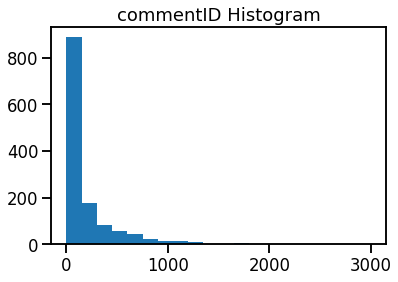

In [43]:
#since each row represents a comment, group by article and save
article_group = df.groupby(by='articleID').count()

quick_look(article_group, 'commentID', (0,3000), 20)

In understanding what metrics make articles successful, I want to look at how many total comments a given article has. Although each row represents a comment

In [44]:
#save the total number of comments for the given article
df['article_comment_total'] = df['articleID'].apply(lambda x: article_group['commentID'][x])

In [45]:
#group data by articles, aggregated by mean
article_sections = df.groupby(['newDesk_x']).mean()

#find out how many comments on average per section
article_sections['article_comment_total']

#quick_look(article_sections, 'commentID', (0,3000), 20)

newDesk_x
Arts&Leisure         45.241449
BookReview          567.117761
Business            942.381843
Climate             659.906564
Culture             447.141578
Dining              173.668622
Editorial           721.511045
Express             727.716763
Foreign             376.855067
Games               115.269935
Insider              94.669173
Investigative       764.772205
Learning            442.745052
Magazine            512.066643
Metro               278.060062
Metropolitan        203.882022
NYTNow               16.055556
National            430.648418
NewsDesk           1014.400980
Obits               421.820823
OpEd                692.985281
Photo                13.967742
Podcasts              2.142857
Politics            950.525719
RealEstate           79.224051
Science             411.371908
Smarter Living       53.036364
Society              99.000000
SpecialSections     119.144000
Sports              420.493827
Styles              239.896989
Summary               6.00000

In [46]:
#drop by section

# top_sections = ['OpEd', 
#                 'Business', 
#                 'NewsDesk', 
#                 'Washington', 
#                 'Foreign', 
#                 'National', 
#                 'Editorial']

# sections_to_drop = [item for item in list(df['newDesk_x'].unique()) if item not in top_sections]

# display(len(list(df['newDesk_x'].unique())))
# display(len(top_sections))
# display(len(sections_to_drop))


In [47]:
#update the publication date to a datetime object
df['pubDate'] = pd.to_datetime(df['pubDate'])

#divide data in half by date, taking the articles that were published in the first half of the month
df = df.loc[df['pubDate'] < '2018-4-15']

if print_detail:
  display(df.shape)

(123692, 16)

comment length

In [48]:
df.columns

Index(['articleID', 'articleWordCount_x', 'commentBody', 'commentID',
       'commentType', 'depth', 'editorsSelection', 'newDesk_x',
       'recommendations', 'replyCount', 'timespeople', 'trusted',
       'documentType', 'headline', 'pubDate', 'article_comment_total'],
      dtype='object')

In [49]:
df['comment_length'] = df['commentBody'].apply(lambda x: len(x.split()))

In [50]:
article_group_sum = df.groupby(by='articleID').sum()
article_group_sum

,articleWordCount_x,commentID,depth,editorsSelection,recommendations,replyCount,timespeople,trusted,article_comment_total,comment_length
articleID,,,,,,,,,,
5abcf77c068401528a29efbe,4554.0,1.593830e+08,7.0,0,6,1,5,0,36,451
5abcfffe068401528a29f021,3501.0,2.388898e+08,10.0,0,47,1,8,0,81,200
5abd03ab068401528a29f062,202095.0,3.582519e+09,199.0,1,1029,77,130,7,18225,7348
5abd080c068401528a29f099,108875.0,1.778602e+09,87.0,0,640,21,60,1,4489,6248
5abd0a47068401528a29f0b3,131355.0,2.786208e+09,143.0,0,969,39,101,4,11025,7365
...,...,...,...,...,...,...,...,...,...,...
5ad248af068401528a2a8b82,401246.0,1.173989e+10,585.0,7,9757,170,414,12,192721,33259
5ad248b3068401528a2a8b84,1275185.0,1.575088e+10,749.0,8,10716,172,552,15,346921,52291
5ad248b8068401528a2a8b85,130402.0,3.022206e+09,159.0,6,1674,62,103,6,12769,8995


replyCount: replies to that comment
article_reply_total: total number of replies

In [51]:
#save the total number of comments for the given article
df['article_reply_total'] = df['articleID'].apply(lambda x: article_group_sum['replyCount'][x])
df['article_rec_total'] = df['articleID'].apply(lambda x: article_group_sum['recommendations'][x])

In [52]:
def flag_highest_adjusted(new_col, continuous_col, group_col='articleID', quant_val = 0.9):
    '''new_col = name of the column to be created
        continuous_col = name of the column to be turned into a binary flag
        group_call = (optional) name of the column to aggregate on, default is article
        quant_val = percentile value to use as threshold for flagging variable'''
    #create a list of all sections
    sections = list(df['newDesk_x'].unique())

    #create an empty dictionary
    percentiles = {}

    #populate with section names and the 90th percentile value of given parameter
    for i in sections:
        percentiles[i] = df.loc[df['newDesk_x'] == i].groupby(group_col).mean()[continuous_col].quantile(quant_val)

    # function to label articles as highly commented if they fall in the 90th percentile of comments for their section
    def flag_upper_percentile(section, value):
        '''accepts a section title and total number of comments for a given article as parameters
        uses the above dictionary to determine whether the given article's total comment count is
        in the 90th percentile
        if so, flags as true''' 
        if value > percentiles[section]:
            return True
        else:
            return False
    #create new column from flagged variable
    df[new_col] = df.apply(lambda x: flag_upper_percentile(x['newDesk_x'], x[continuous_col]), axis=1)

In [53]:
#at the article level, turn total comments, total recommendations, and total replies into boolean variables
flag_highest_adjusted('highly_commented', 'article_comment_total')
flag_highest_adjusted('high_total_recommendations', 'article_rec_total')
flag_highest_adjusted('high_total_reply', 'article_reply_total')

In [54]:
#add in the article reccomendation total and article reply total
df['article_rec_total'] = df['articleID'].apply(lambda x: article_group_sum['recommendations'][x])
df['article_reply_total'] = df['articleID'].apply(lambda x: article_group_sum['replyCount'][x])

df['depth_total'] = df['articleID'].apply(lambda x: article_group_sum['depth'][x])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123692 entries, 48395 to 203986
Data columns (total 23 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   articleID                   123692 non-null  object        
 1   articleWordCount_x          123692 non-null  float64       
 2   commentBody                 123692 non-null  object        
 3   commentID                   123692 non-null  float64       
 4   commentType                 123692 non-null  object        
 5   depth                       123692 non-null  float64       
 6   editorsSelection            123692 non-null  bool          
 7   newDesk_x                   123692 non-null  object        
 8   recommendations             123692 non-null  int64         
 9   replyCount                  123692 non-null  int64         
 10  timespeople                 123692 non-null  int64         
 11  trusted                     123692 

In [55]:
df['depth_ratio'] = df.apply(lambda x: int(x['depth_total']) / x['article_comment_total'], axis=1)

[(0.0, 4000.0)]

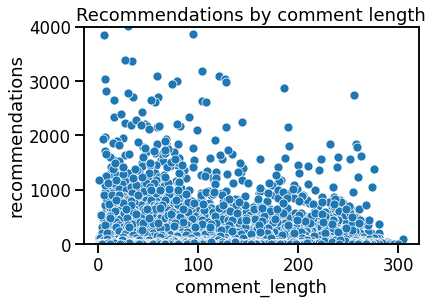

In [56]:
import seaborn as sns
sns.set_context('talk')
ax = sns.scatterplot(data=df, x='comment_length', y='recommendations')
ax.set(title ='Recommendations by comment length')
ax.set(ylim = (0,4000))

### High-Engagement Articles

list of visualizations:

by section: articles that are highly rated, highly commented, and high total reply

replace reply count w average depth

### Comment Analysis

In understanding what kind of comments generate the most engagement, I anticipate a wide range of variation in terms of how long comments are. I'm interested to understand how the length of a comment plays into how many replies or recommendations the comment gets. Here I engineer the commentLength feature, which measures the number of words in a given comment.

,commentLength,commentBody
48395,10,Am I the only one who doesn’t get 29D? Help!
48396,26,Thought answer to 39 down — Proceed well enoug...
48397,20,"Though the theme answers were quite easy, as w..."
48398,52,The issue with 39D could have been completely ...
48399,36,Alex<br/><br/>I really enjoyed this puzzle. <b...
...,...,...
203982,4,One word: Wade Boggs
203983,66,I feel like I just lost my right to claim I'm ...
203984,241,"It's not only steroids, it's the glitz and noi..."
203985,41,"Bill,<br/><br/>I know. I grew up watching Wade..."


commentLength description: 


count    123692.000000
mean         66.098333
std          59.213225
min           1.000000
25%          23.000000
50%          47.000000
75%          89.000000
max         305.000000
Name: commentLength, dtype: float64

14     1686
13     1679
15     1675
20     1666
16     1659
       ... 
290       1
296       1
300       1
303       1
305       1
Name: commentLength, Length: 297, dtype: int64

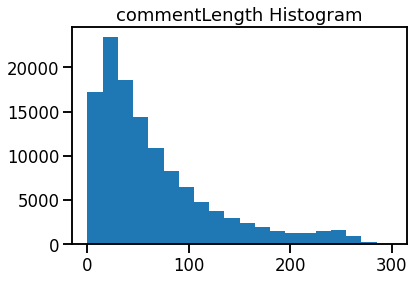

In [57]:
#engineer comment length feature. 
df['commentLength'] = df['commentBody'].apply(lambda x: len(x.split()))

if print_detail:
    display(df[['commentLength', 'commentBody']])

quick_look(df, 'commentLength', (0, 300), 20)

recommendations description: 


count    123692.000000
mean         19.421620
std          99.624274
min           0.000000
25%           1.000000
50%           4.000000
75%          11.000000
max        8713.000000
Name: recommendations, dtype: float64

0       19672
1       15767
2       12280
3        9728
4        7863
        ...  
2144        1
481         1
673         1
801         1
2783        1
Name: recommendations, Length: 955, dtype: int64

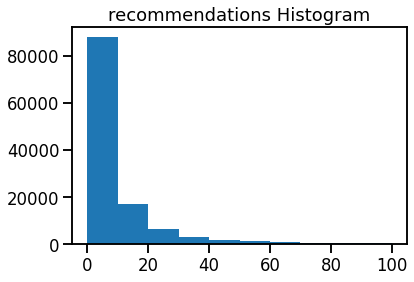

In [58]:
quick_look(df, 'recommendations', (0, 100))

In [59]:
# VIZ: plot comment length against number of recommendations

In [60]:
#feature engineer recommendations into highly recommended
recommendations_threshold = df['recommendations'].quantile(0.9)
df['highly_recommended'] = df['recommendations'].apply(lambda x: True if x > recommendations_threshold else False)
df['recommended'] = df['recommendations'].apply(lambda x: True if x > 0 else False)
if print_detail:
    display(df['recommended'].value_counts())
    display(df['highly_recommended'].value_counts())

True     104020
False     19672
Name: recommended, dtype: int64

False    111710
True      11982
Name: highly_recommended, dtype: int64

replyCount description: 


count    123692.000000
mean          0.420270
std           2.955607
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         668.000000
Name: replyCount, dtype: float64

0      100609
1       13339
2        4596
3        2060
4        1040
5         643
6         372
7         243
8         183
9         125
10         98
11         78
12         52
13         43
14         28
15         26
17         22
16         13
18         13
22         10
21         10
23         10
20          9
19          7
25          6
24          5
29          5
30          5
36          4
28          3
31          3
26          3
32          2
54          2
45          2
37          2
35          2
55          2
33          1
208         1
89          1
52          1
130         1
113         1
46          1
69          1
42          1
105         1
41          1
40          1
39          1
38          1
668         1
530         1
61          1
Name: replyCount, dtype: int64

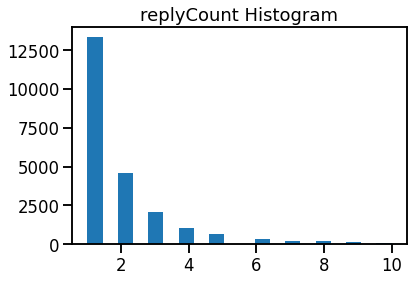

In [61]:
#reply count
quick_look(df, 'replyCount', (1, 10), 20)

In [62]:
#VIZ plot comment length against reply count

In [63]:
#feature engineering reply count into categorical

df['replied_to'] = df['replyCount'].apply(lambda x: True if x > 0 else False)
df['highly_replied_to'] = df['replyCount'].apply(lambda x: True if x > 5 else False)

if print_detail:
    display(df['replied_to'].value_counts())
    display(df['highly_replied_to'].value_counts())

False    100609
True      23083
Name: replied_to, dtype: int64

False    122287
True       1405
Name: highly_replied_to, dtype: int64

In [64]:
df.loc[df['replyCount'] < 0]

,articleID,articleWordCount_x,commentBody,commentID,commentType,depth,editorsSelection,newDesk_x,recommendations,replyCount,timespeople,trusted,documentType,headline,pubDate,article_comment_total,comment_length,article_reply_total,article_rec_total,highly_commented,high_total_recommendations,high_total_reply,depth_total,depth_ratio,commentLength,highly_recommended,recommended,replied_to,highly_replied_to


depth description: 


count    123692.000000
mean          1.323877
std           0.503636
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           4.000000
Name: depth, dtype: float64

1.0    85768
2.0    35794
3.0     2123
4.0        7
Name: depth, dtype: int64

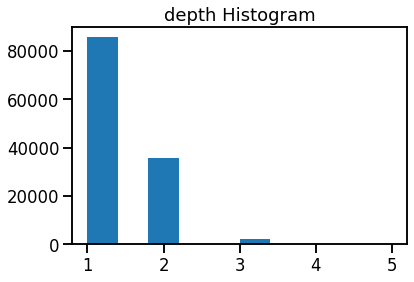

In [65]:
#depth
quick_look(df, 'depth', (1, 5))

editorsSelection description: 


count     123692
unique         2
top        False
freq      121825
Name: editorsSelection, dtype: object

False    121825
True       1867
Name: editorsSelection, dtype: int64

<string>:6: RuntimeWarning:

Converting input from bool to <class 'numpy.uint8'> for compatibility.



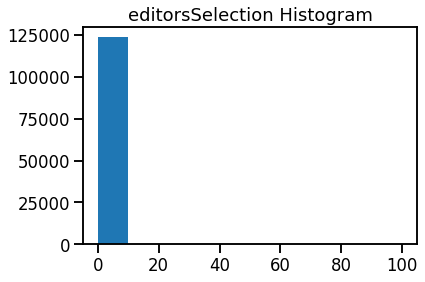

In [66]:
#editor selected
quick_look(df, 'editorsSelection', (0, 100))

timespeople description: 


count    123692.000000
mean          0.915726
std           0.277799
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: timespeople, dtype: float64

1    113268
0     10424
Name: timespeople, dtype: int64

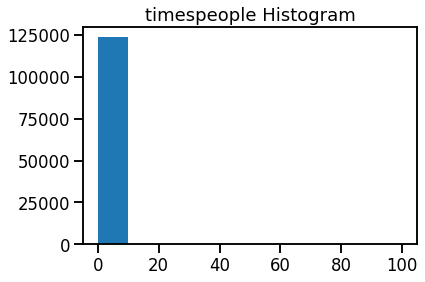

In [67]:
#timespeople
quick_look(df, 'timespeople', (0, 100))

trusted description: 


count    123692.000000
mean          0.033082
std           0.178852
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: trusted, dtype: float64

0    119600
1      4092
Name: trusted, dtype: int64

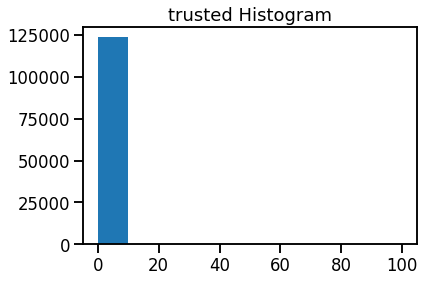

In [68]:
#trusted
quick_look(df, 'trusted', (0, 100))

In [69]:
#VIZ plot visualization of all, highly recommended, and highly replied comments
ys = [df, df.loc[df['highly_recommended'] == True], df.loc[df['highly_replied_to'] == True]]


### Feature Engineering Abuse Flag

In [70]:
# using this function to detect if we have any abusive comments

# def get_top_hs_class(sonar_obj, comment):
#     '''accepts a HateSonar Sonar object and a string comment (unprocessed) and returns the class with 
#     the highest confidence score.
#     Class options are: hate speech, offensive language, neither'''
#     results = sonar_obj.ping(text=comment)

#     # hs_conf = results['classes']['class_name' == 'hate_speech']['confidence']
#     # off_conf = results['classes']['class_name' == 'offensive_language']['confidence']
#     # none_conf = results['classes']['class_name' == 'neither']['confidence']

#     return results['top_class']

In [71]:
# sonar = Sonar()
# df['hateSonar_result'] = df['commentBody'].apply(lambda x: get_top_hs_class(sonar, x))

In [72]:
# pd.set_option('display.max_colwidth', 0)

# # display(df['hateSonar_result'].value_counts())

# # display(df['commentBody'].loc[df['hateSonar_result'] == 'hate_speech'])
# # display(df['commentBody'].loc[df['hateSonar_result'] == 'offensive_language'])

In [73]:
# # using this function to detect if we have any abusive comments

# def bool_top_hs_class(sonar_obj, comment):
#     '''accepts a HateSonar Sonar object and a string comment (unprocessed) and runs the hateSonar program.
#     If the comment is more likely than not to be either hate speech or offensive language, the program will 
#     Class options are: hate speech, offensive language, neither'''
    
#     #likelihood that speech is NOT hate speech must be lower than this value to be flagged
#     threshold = 0.03
    
#     #run hateSonar
#     results = sonar_obj.ping(text=comment)

#     #initially save top result as the label
#     label = results['top_class']

#     #if the initial label is hate speech or offensive language
#     if label == 'neither':
#         label = False
#     elif results['classes']['class_name' == 'neither']['confidence'] > threshold:
#         label = False
#     else:
#         label = True
        
#     return label

In [74]:
# df['hateSonar_abuse_flag'] = df['commentBody'].apply(lambda x: bool_top_hs_class(sonar, x))

In [75]:
# df['hateSonar_abuse_flag'].value_counts()

In [76]:
# df['commentBody'].loc[df['hateSonar_abuse_flag'] == True]

In [77]:
# df_sections = df.groupby(by='newDesk_x').sum()
# df_sections['hateSonar_abuse_flag']

In [78]:
# df.columns

Limitations: hate sonar detects problematic speech where there isn't any. It flags good-faith discussions of race, faith, sex/gender, suicide, and other topics sensitive topics. It also (understandably) struggles with quotes and sarcasm. 
It could also be missing problematic speech.
An interesting takeaway from this is that context is incredibly important for training hate speech detection tools. Hate speech in the comments of New York Times articles is likely to look very different from objectionable speech on Twitter at large, for example. 

## Data Preprocessing

In [79]:
from io import StringIO
from html.parser import HTMLParser

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [80]:
#test run for processing a single string - want to functionalize
#integers = []

# def lower_and_sw_filter(comment_str):
#     ''' this function returns a string with all the characters converted to lowercase
#     and all stopwords and punctuation removed'''
    
#     #strip html tags
#     comment_str = strip_tags(comment_str)
    
#     #lowercase
#     comment_str = comment_str.lower()

#     #tokenize
#     tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

#     comment_str = tokenizer.tokenize(comment_str)

#     #stopwords

#     filtered = list(filter(lambda x: x.lower() not in stopwords_set, comment_str))

#     #lemmatize

#     lemmatizer = WordNetLemmatizer()
#     lemma = []
#     for word in filtered:
# #         #print(word)
# #         if word.isdigit():
# #             int_list.append(word)
        
#         lemmatized_word = lemmatizer.lemmatize(word)
#         lemma.append(lemmatized_word)
    
#     lemma = ' '.join(lemma)
    
#     return lemma

In [81]:
#test run for processing a single string - want to functionalize
#integers = []

corpus = []

def lower_and_sw_filter(comment_str, corpus_list):
    ''' this function returns a string with all the characters converted to lowercase
    and all stopwords and punctuation removed'''
    
    #strip html tags
    comment_str = strip_tags(comment_str)
    
    #lowercase
    comment_str = comment_str.lower()

    #tokenize
    tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')

    comment_str = tokenizer.tokenize(comment_str)

    #stopwords

    filtered = list(filter(lambda x: x.lower() not in stopwords_set, comment_str))

    #lemmatize

    lemmatizer = WordNetLemmatizer()
    lemma = []
    for word in filtered:
#         #print(word)
#         if word.isdigit():
#             int_list.append(word)
        
        lemmatized_word = lemmatizer.lemmatize(word)
        lemma.append(lemmatized_word)
    corpus_list = corpus_list + lemma
    lemma = ' '.join(lemma)
    
    return lemma

In [82]:
df['processed_comment'] = df['commentBody'].apply(lambda x: lower_and_sw_filter(x, corpus))
df.drop('commentBody', axis=1, inplace=True)
df.columns

Index(['articleID', 'articleWordCount_x', 'commentID', 'commentType', 'depth',
       'editorsSelection', 'newDesk_x', 'recommendations', 'replyCount',
       'timespeople', 'trusted', 'documentType', 'headline', 'pubDate',
       'article_comment_total', 'comment_length', 'article_reply_total',
       'article_rec_total', 'highly_commented', 'high_total_recommendations',
       'high_total_reply', 'depth_total', 'depth_ratio', 'commentLength',
       'highly_recommended', 'recommended', 'replied_to', 'highly_replied_to',
       'processed_comment'],
      dtype='object')

In [83]:
# from collections import Counter

# # corpus = []
# # for each in df['processed_comment']:
# #   corpus = corpus + each.split()
# counted = Counter(corpus)

# word_freq = pd.DataFrame(counted.items(),columns=['word','frequency']).sort_values(by='frequency',ascending=False)

# word_freq.head(10)

### EDA Conclusions

## Modeling 

### Additional preprocessing for modeling

Initially, I had hoped to use only the processed text data to make predictions about the number of recommendations the comment would earn. Given the difficulties I encountered with running models with any meaningful amount of data, I chose to add in some additional relevant features in hopes of helping the model. Below is my final selection of columns for the model.

In [84]:
display(df.columns)

keep = ['articleWordCount_x', 'commentType', 'depth',
       'editorsSelection', 'newDesk_x', 'replyCount',
       'timespeople', 'trusted', 'documentType', 
       'article_comment_total', 'article_reply_total', 
        'commentLength', 'highly_recommended', 
        'processed_comment']

df = reverse_drop(df, keep)
df.columns

Index(['articleID', 'articleWordCount_x', 'commentID', 'commentType', 'depth',
       'editorsSelection', 'newDesk_x', 'recommendations', 'replyCount',
       'timespeople', 'trusted', 'documentType', 'headline', 'pubDate',
       'article_comment_total', 'comment_length', 'article_reply_total',
       'article_rec_total', 'highly_commented', 'high_total_recommendations',
       'high_total_reply', 'depth_total', 'depth_ratio', 'commentLength',
       'highly_recommended', 'recommended', 'replied_to', 'highly_replied_to',
       'processed_comment'],
      dtype='object')

Index(['articleWordCount_x', 'commentType', 'depth', 'editorsSelection',
       'newDesk_x', 'replyCount', 'timespeople', 'trusted', 'documentType',
       'article_comment_total', 'article_reply_total', 'commentLength',
       'highly_recommended', 'processed_comment'],
      dtype='object')

I then sorted the columns by type for preprocessing.

In [85]:
df.info()

continuous = ['articleWordCount_x', 'replyCount', 'article_comment_total', 'article_reply_total', 'commentLength']

categorical = ['commentType', 'depth', 'newDesk_x', 'documentType']

boolean = ['timespeople', 'trusted', 'editorsSelection']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123692 entries, 48395 to 203986
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   articleWordCount_x     123692 non-null  float64
 1   commentType            123692 non-null  object 
 2   depth                  123692 non-null  float64
 3   editorsSelection       123692 non-null  bool   
 4   newDesk_x              123692 non-null  object 
 5   replyCount             123692 non-null  int64  
 6   timespeople            123692 non-null  int64  
 7   trusted                123692 non-null  int64  
 8   documentType           123692 non-null  object 
 9   article_comment_total  123692 non-null  int64  
 10  article_reply_total    123692 non-null  int64  
 11  commentLength          123692 non-null  int64  
 12  highly_recommended     123692 non-null  bool   
 13  processed_comment      123692 non-null  object 
dtypes: bool(2), float64(2), int64(6)

In [86]:
# boolean preprocessing
for each in boolean:
  print(df[each].unique())
  df[each] = df[each].astype(bool)

df[boolean].info()

[1 0]
[0 1]
[False  True]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 123692 entries, 48395 to 203986
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   timespeople       123692 non-null  bool 
 1   trusted           123692 non-null  bool 
 2   editorsSelection  123692 non-null  bool 
dtypes: bool(3)
memory usage: 1.3 MB


I one-hot-encoded the categorical variables as is standard.

In [87]:
#categorical preprocessing
df[categorical].info()
df['depth'] = df['depth'].astype(object)

ohe = pd.get_dummies(df[categorical], prefix = categorical)

df = df.join(ohe)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123692 entries, 48395 to 203986
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   commentType   123692 non-null  object 
 1   depth         123692 non-null  float64
 2   newDesk_x     123692 non-null  object 
 3   documentType  123692 non-null  object 
dtypes: float64(1), object(3)
memory usage: 4.7+ MB


And I used a Standard Scaler on the continuous data.

In [88]:
#continuous preprocessing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

for each in continuous:

  temp = np.array(df[each])
  temp = temp.reshape(-1, 1)
  scaler.fit(temp)
  df[each] = scaler.transform(temp)



### Predicting Recommendations

I split the data in to training and testing data, with my engineered 'highly recommended' variable as the outcome. I chose to use this variable as the outcome because it was most impactful in terms of the business case. To be able to detect which comments would fall in the top 90th percentile of comments would have been a pretty powerful affirmation of my business case. Had it been successful, I would have also tried to predicted highly replied articles and editor selected articles as well. 

In [89]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('highly_recommended', axis=1), 
                                                    df['highly_recommended'], 
                                                    random_state=714)

I used a TF-IDF vectorizer to vectorize and transform the text data in a single step. This was the site of some of my major data size issues. I found that the vectorizer couldn't handle too much data, and was forced to limit both the number of rows and columns. I was extremely hesitant to lose data, so I spent quite a bit of time ascertaining the maximum number of viable rows and columns for this function. 

In [90]:
def tfidfify(train_text, test_text, tfidf=None):
    if not tfidf:
        tfidf = TfidfVectorizer(stop_words='english', dtype=np.float32, max_features = 10000)
    tfidf.fit(train_text)
    train_processed = tfidf.transform(train_text)
    test_processed = tfidf.transform(test_text)

    columns = tfidf.get_feature_names()
    return (
        pd.DataFrame(train_processed.toarray()),
        pd.DataFrame(test_processed.toarray()),
        columns
    )

In [91]:
vect = TfidfVectorizer(stop_words='english', dtype=np.float32, max_features = 30000)
train_processed, test_processed, feat_names = tfidfify(X_train['processed_comment'], X_test['processed_comment'], vect)

print('Training Data shape:')
display(train_processed.shape)
print('Testing Data shape:')
display(test_processed.shape)

Training Data shape:


(92769, 30000)

Testing Data shape:


(30923, 30000)

When I experienced issues with the TF-IDF vectorizer, I thought that separating the vectorizing and transforming steps might lighten the processing load. Ultimately, this ended up being irrelevant as the size of the data became an issue with the modeling itself. I also compared the two processing methods in the models, and got identical results.

In [92]:
text_processing = Pipeline([
    ('vect', CountVectorizer(max_features=30000)),
    ('tfidf', TfidfTransformer())
])

In [93]:
text_processing.fit(X_train['processed_comment'])

processed_train = text_processing.transform(X_train['processed_comment'])
processed_test = text_processing.transform(X_test['processed_comment'])

print('Training Data shape:')
display(processed_train.shape)
print('Testing Data shape:')
display(processed_test.shape)

Training Data shape:


(92769, 30000)

Testing Data shape:


(30923, 30000)

I also considered using PCA to decompose the data and remove some dimensionality, in hopes of reducing the required processing cost. However, the threshold for the amount of data that the PCA function could handle was similar to the amount of un-decomposed data that the functions could handle, which resulted in Colab crashing at the PCA function rather than the modelling function. 

In [94]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components = 10000)
# pca.fit_transform(train_processed)
# print(np.sum(pca.explained_variance_ratio_))

In [95]:
def run_model(model, x_train = processed_train, x_test=processed_test, y_train=y_train, y_test=y_test):
  '''This function accepts a model and runs it, along with the classification report. It comes with default
  testing and training data specified, but allows for the specification of different data as well'''
  model.fit(x_train.toarray(), y_train.values.ravel())

  y_hat_test = model.predict(processed_test)
  print(classification_report(y_test, y_hat_test))

In [96]:
#initial models
logreg = LogisticRegression(class_weight = 'balanced', max_iter=500)
rforest = RandomForestClassifier(class_weight= 'balanced', n_estimators = 3)

In [97]:
run_model(logreg)

              precision    recall  f1-score   support

       False       0.93      0.74      0.82     27990
        True       0.16      0.47      0.24      2933

    accuracy                           0.71     30923
   macro avg       0.54      0.61      0.53     30923
weighted avg       0.86      0.71      0.77     30923



In [98]:
#attempting the logistic regression model without balanced classes
logreg1 = LogisticRegression(max_iter=500)
run_model(logreg1)

              precision    recall  f1-score   support

       False       0.91      1.00      0.95     27990
        True       0.39      0.00      0.01      2933

    accuracy                           0.90     30923
   macro avg       0.65      0.50      0.48     30923
weighted avg       0.86      0.90      0.86     30923



At the recommendation of a Medium article, I also attempted to use a label encoder for my categorical variables instead of a one-hot-encoder. There was no improvement in the model's performance, which is understandable as the categorical variables are only a handful out of the final 30,000. 

In [99]:
# Label Encode instead of dummy variables

mappings = []

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

label_df = df.copy(deep=True)
for i, col in enumerate(label_df):
    if col == 'processed_comment':
      print("skipping text var")
    elif label_df[col].dtype == 'object':
        label_df[col] = label_encoder.fit_transform(np.array(label_df[col].astype(str)).reshape((-1,)))
        mappings.append(dict(zip(label_encoder.classes_, range(1, len(label_encoder.classes_)+1))))

skipping text var


In order to test my one-hot-encoding versus label encoding hypothesis, I re-split and re-processed the data.

In [100]:
X_train, X_test, y_train, y_test = train_test_split(label_df.drop('highly_recommended', axis=1), 
                                                    label_df['highly_recommended'], 
                                                    random_state=714)

In [101]:
text_processing.fit(X_train['processed_comment'])

processed_train_label = text_processing.transform(X_train['processed_comment'])
processed_test_label = text_processing.transform(X_test['processed_comment'])

print('Training Data shape:')
display(processed_train_label.shape)
print('Testing Data shape:')
display(processed_test_label.shape)

Training Data shape:


(92769, 30000)

Testing Data shape:


(30923, 30000)

In [ ]:
run_model(logreg, x_train=processed_train_label, x_test = processed_test_label)

In [ ]:
run_model(rforest)

In [ ]:
# from sklearn.model_selection import GridSearchCV

# grid_params = {
#     'criterion' : ['gini', 'entropy'],
#     'n_estimators' : [5, 10],
#     'max_features' : [10000, 20000]
# }

# forest_search = RandomForestClassifier(class_weight = 'balanced')
# rforest = GridSearchCV(forest_search, grid_params, cv = 5)

# run_model(rforest)

In [ ]:
# from sklearn.tree import DecisionTreeClassifier

# tree = DecisionTreeClassifier(class_weight='balanced')

# run_model(tree)

## Evaluation

Although my results are less than ideal, I wanted to take a moment to explain the process for this project. My original goal was to use many more data points (potentially up to 1 million) and and unrestricted number of TF-IDF columns. That goal quickly proved unrealistic, as even fitting the TF-IDF model to that number of data points would have demanded over 1 TB of RAM.

In addition to the size restrictions on the data mentioned previously, I was also limited by the processing power at my disposal. With the data at the current size, I was unable to run additional models due to the amount of RAM they would have required to process a model of that size. Given that I was already severely limiting the quality of the data, I did not want to whittle down the data further in order to run models on an ineffective data set. I had hoped to develop models using: support vector machines, naive Bayes, and XGBoost - none of which were able to work with this dataset with the given RAM. Even attempts to reduce the dimensionality of the data failed, as I was unable to fit a PCA decomposer with the limited processing power.


| model name | precision | recall | accuracy |
---|---|---|---|
| logistic regression | 94/16 | 74/47 | 71% |
| random forest |  91/12 | 98/3 | 89% |


Attempted Models:


*   Support Vector Machine
*   Decision Tree Classifier
*   Naive Bayes
*   Grid Search (for Random Forest or Decision Tree)

Each of these models used too much RAM or computation time to be effective.



## Conclusions